In [1]:
#***********************************************************************************************#
# Implementación del circuito de Teletransportación Cuántica en la plataforma Qiskit de IBM.
#***********************************************************************************************#

#***********************************************************************************************#
# Para esta implementación se ha tenido en cuenta la descripción del circuito dada en el siguiente 
# tutorial del libro de Qiskit:
# https://qiskit.org/textbook/ch-algorithms/teleportation.html

# Además se han tomando instrucciones e ideas del tutorial de la comunidad de desarrolladores de Qiskit disponible en:
# https://github.com/Qiskit/qiskit-community-tutorials/blob/master/terra/qis_intro/teleportation_superdensecoding.ipynb
#***********************************************************************************************#

#***********************************************************************************************#
# Curso de Computación Cuántica
# Prof. Gustavo Patino
# Departamento de Ingeniería Electrónica y Telecomunicaciones
# Facultad de Ingeniería
# Universidad de Antioquia
# Medellin, 2020-2022.
#***********************************************************************************************#

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [3]:
from qiskit_textbook.tools import random_state, vector2latex
from qiskit.extensions import Initialize

In [4]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [5]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [6]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica

In [7]:
def crear_estado_bell00(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

In [8]:
def circuito_de_alice(qc, q2send, beta0):
    qc.cx(q2send, beta0)
    qc.h(q2send)

In [9]:
def medicion_de_alice(qc, a, b):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)
    qc.barrier()
    qc.barrier()

In [10]:
def circuito_de_bob(qc, beta1, m1, m2):
    qc.z(beta1).c_if(m1, 1)
    qc.x(beta1).c_if(m2, 1)

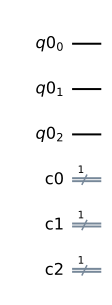

In [11]:
# Definición del circuito de teletransportación cuántica

qr = QuantumRegister(3)
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)
crbob = ClassicalRegister(1)
teleport_cir = QuantumCircuit(qr, crz, crx, crbob)

teleport_cir.draw('mpl')

[-0.53911553+0.14912674j -0.51080345+0.6528365j ]


<IPython.core.display.Math object>

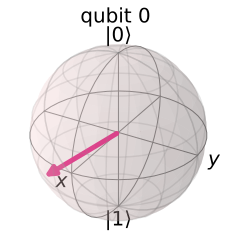

In [12]:
# si la función random_set no está disponible en su instalación del Qiskit, entonces comente las siguientes instrucciones.
# Luego descomente la instrucción de rotación mostrada en la siguiente linea.
qrandom = random_state(1)
print(qrandom)
vector2latex(qrandom, pretext="|\\psi\\rangle =")

plot_bloch_multivector(qrandom)

In [13]:
# Descomente estas instrucciones si el comando Random_set() no está disponible en su instalación del qiskit
#teleport_cir.reset(qr[0])
#teleport_cir.ry(np.pi/10,qr[0]) 
#teleport_cir.barrier()
#teleport_cir.draw('mpl')

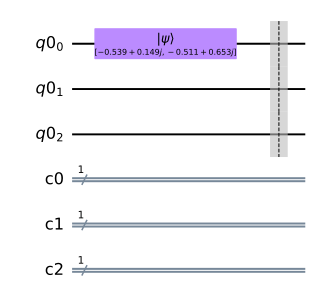

In [14]:
# Comente estas instrucciones si el comando Random_set() no está disponible en su instalación del qiskit
init_gate =Initialize(qrandom)
teleport_cir.append(init_gate, [0])

teleport_cir.barrier()
teleport_cir.draw('mpl')

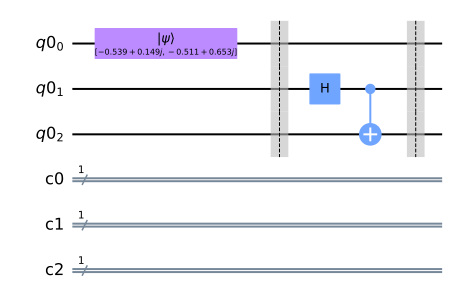

In [15]:
crear_estado_bell00(teleport_cir, qr[1], qr[2])
teleport_cir.barrier()
teleport_cir.draw('mpl')

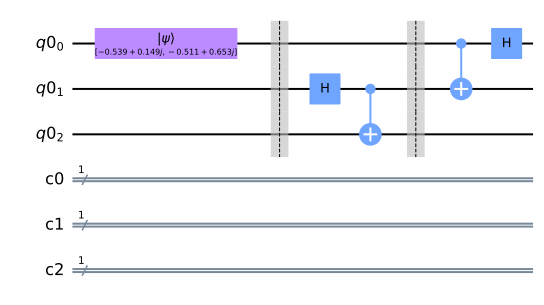

In [16]:
circuito_de_alice(teleport_cir, qr[0], qr[1])
teleport_cir.draw('mpl')

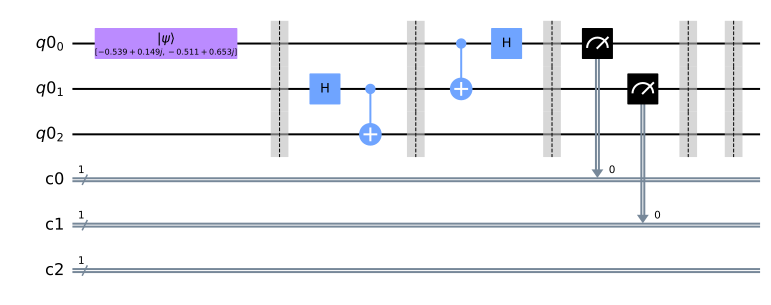

In [17]:
medicion_de_alice(teleport_cir, qr[0], qr[1])
teleport_cir.draw('mpl')

# El resultado de la medida realizada por Alice 
# se envía a Bob por un canal clásico (correo electronico, Whatsapp, llamada telefónica).
# Este canal clásico se representa por la doble barrera indicada en el circuito.

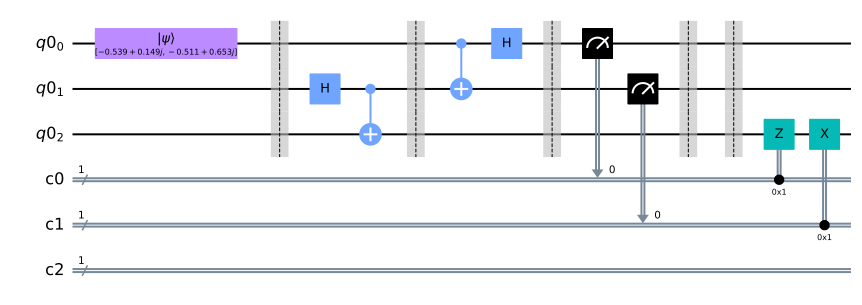

In [18]:
circuito_de_bob(teleport_cir, qr[2], crz, crx)
teleport_cir.draw('mpl')

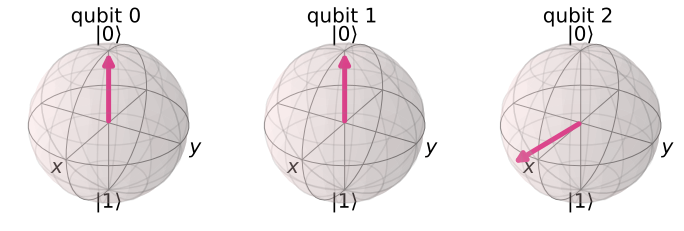

In [19]:
backend = Aer.get_backend('statevector_simulator')
out_vector = execute(teleport_cir, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

#Los qubits 0 y 1 están colapsados como se indica en las siguientes figuras. El qubit2 es el recibido por Bob.
#El qubit2 debe corresponder al qubit enviado por Alice en los pasos anteriores.

In [20]:
vector2latex(out_vector, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [ ]:
#mag_squared = 0
#for a in bob:
#    mag_squared = abs(a)**2
#    print(mag_squared)

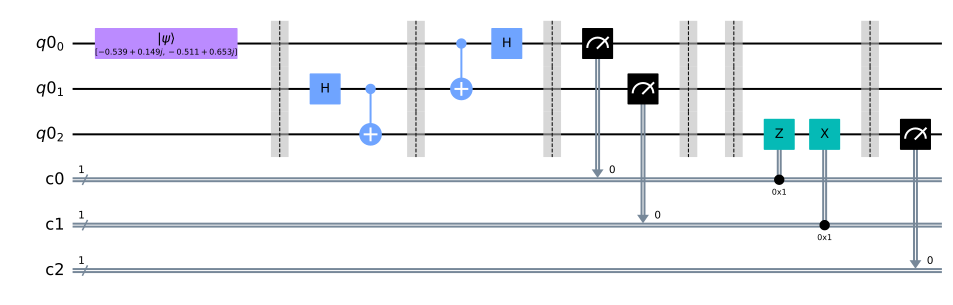

In [21]:
teleport_cir.barrier() # Use barrier to separate steps
teleport_cir.measure(qr[2], crbob[0])
teleport_cir.draw('mpl')

In [22]:
local_backend = Aer.get_backend('qasm_simulator') # note that this circuit can not be run on an IBM Q device
teleport_job = execute(teleport_cir, local_backend, shots=1024) 
teleport_result = teleport_job.result()

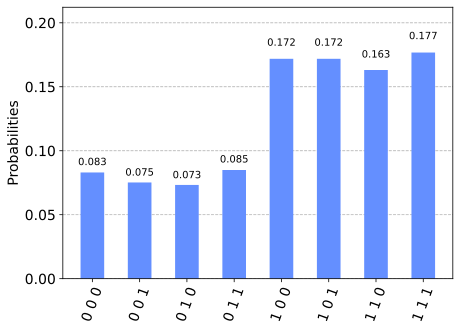

In [23]:
data = teleport_result.get_counts(teleport_cir)
plot_histogram(data)

# En este conjunto de datos de probabilidad está todo el universo del circuito. 
# Los qubits q0 y q1 corresponden a los obtenidos por Alice antes de la medida.
# Y el qubit q2 corresponde al recibido por Bob. 

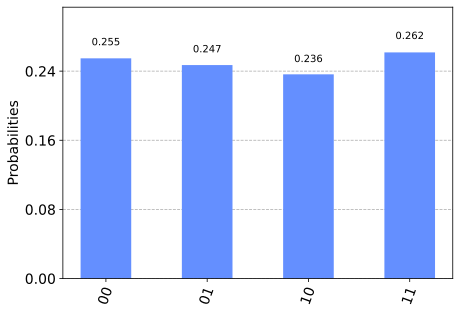

In [24]:
# Con las siguientes instrucciones se pueden extraer de manera más clara los qubits de Alice.
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

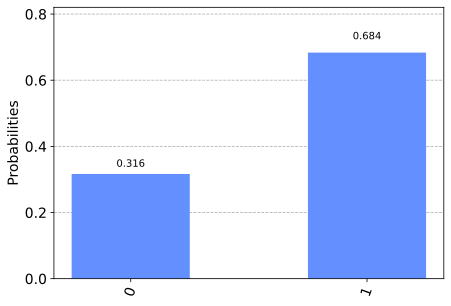

In [25]:
# Y con las siguientes instrucciones se puede extraer de manera más clara el qubit de Bob.
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)

In [ ]:
# Este circuito, como fue descrito en este código, no puede ser implementado en un computador cuántico real de IBM 
# debido a la imposibilidad de agregar compuertas cuánticas luego de que se realice alguna medida.

# Además de ello, en un circuito real de teletransportación cuántica, sería necesario que el circuito de Bob estuviera 
# fisicamente en otro lugar separado del circuito real de Alice, y los bits medidos por Alice se deberían enviar 
# clásicamente al circuito de Bob.

# Aun así, en otro ejercicio podremos implementar este circuito en un computador cuántico real a fin de
# evaluar su ejecución y tasa de error.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright